In [ ]:
!pip install botorch
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 481 kB 17.3 MB/s 
     |████████████████████████████████| 245 kB 75.0 MB/s 
     |████████████████████████████████| 152 kB 61.8 MB/s 
     |████████████████████████████████| 727 kB 61.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 20.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import torch
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from botorch.models.multitask import MultiTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.optim import Adam

#**Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import pandas as pd
with open('./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Paper Data/literature_data.json', 'r') as file_1:
    lite_data = pd.read_json(json.load(file_1), orient='table')


In [ ]:

with open('./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Paper Data/experimental_data.json', 'r') as file_2:
    exp_data = pd.read_json(json.load(file_2), orient='table')

In [ ]:
lite_data = lite_data.drop('Units of E', axis=1)
lite_df = lite_data.rename(columns={'Units of A': 'EtOx', 'Units of B': 'nPropOx', 'Units of C': 'cPropOx', 'Units of D': 'iPropOx', 'M':'MW'})

exp_data = exp_data.drop('Units of E', axis=1)
exp_df = exp_data.rename(columns={'Units of A': 'EtOx', 'Units of B': 'nPropOx', 'Units of C': 'cPropOx', 'Units of D': 'iPropOx', 'M':'MW'})

In [ ]:
lite_df = lite_df.reset_index(drop=True)
lite_df.to_csv('literature.csv', index=False)

In [ ]:
lite_df.head()

,No,EtOx,nPropOx,cPropOx,iPropOx,MW,Cloud Point
0,5,100.0,0.0,0,0.0,6700.0,90.6
1,6,150.0,0.0,0,0.0,9000.0,85.3
2,7,200.0,0.0,0,0.0,13300.0,78.3
3,8,300.0,0.0,0,0.0,21000.0,73.5
4,9,500.0,0.0,0,0.0,37300.0,69.3


In [ ]:
exp_df = exp_df.reset_index(drop=True)
exp_df.to_csv('experimental.csv', index=False)

In [ ]:
exp_df.head()

,No,EtOx,nPropOx,cPropOx,iPropOx,MW,Cloud Point
0,9,158.024816,0.0,0.0,0.0,15665,87.50
1,10,90.991627,0.0,0.0,0.0,9020,88.50
2,11,170.654696,0.0,0.0,0.0,16917,86.30
3,14,434.601029,0.0,0.0,0.0,43082,60.75
4,15,388.439423,0.0,0.0,0.0,38506,61.50


Feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
lite_std = lite_df.copy()
lite_std.iloc[:, :-1] = scaler.fit_transform(lite_std.iloc[:, :-1])
exp_std = exp_df.copy()
exp_std.iloc[:, :-1] = scaler.fit_transform(exp_std.iloc[:, :-1])

# **Model Building**

In [ ]:
from sklearn.model_selection import train_test_split

X = lite_std.iloc[:, 1:-1].values
y = lite_std.iloc[:, -1].values

#Seperating literature data to training and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.09333333, random_state=5)

X_test = exp_std.iloc[:, 1:-1].values
y_test = exp_std.iloc[:, -1].values


In [ ]:
# A list for the evaluation result
rmse_sum = {}

## Lasso

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, lasso.predict(X_train))
RMSE_train = mean_squared_error(y_train, lasso.predict(X_train), squared=False)
R_square_val = r2_score(y_val, lasso.predict(X_val))
RMSE_val = mean_squared_error(y_val, lasso.predict(X_val), squared=False)
R_square_test = r2_score(y_test, lasso.predict(X_test))
RMSE_test = mean_squared_error(y_test, lasso.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Validation): {R_square_val}\nRMSE(Validation): {RMSE_val}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.6191847321310633
RMSE(Train): 12.255265352530252

R_square(Validation): 0.8874978268916965
RMSE(Validation): 4.727253595316816

R_square(Test): 0.632104235484147
RMSE(Test): 11.385326596117858


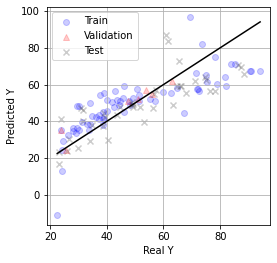

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, lasso.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_val, lasso.predict(X_val), alpha=0.2, c="red", marker='^', label='Validation')
plt.scatter(y_test, lasso.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
rmse_sum['Linear Regression(Lasso)'] = [RMSE_train, RMSE_val, RMSE_test] 

## Ridge

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

Ridge(alpha=0.1)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, ridge.predict(X_train))
RMSE_train = mean_squared_error(y_train, ridge.predict(X_train), squared=False)
R_square_val = r2_score(y_val, ridge.predict(X_val))
RMSE_val = mean_squared_error(y_val, ridge.predict(X_val), squared=False)
R_square_test = r2_score(y_test, ridge.predict(X_test))
RMSE_test = mean_squared_error(y_test, ridge.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Validation): {R_square_val}\nRMSE(Validation): {RMSE_val}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.619367216263466
RMSE(Train): 12.25232868003559

R_square(Validation): 0.8852793974864446
RMSE(Validation): 4.773634402758524

R_square(Test): 0.6286916199150905
RMSE(Test): 11.438010073092833


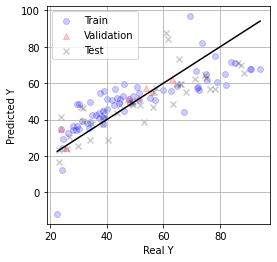

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, ridge.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_val, ridge.predict(X_val), alpha=0.2, c="red", marker='^', label='Validation')
plt.scatter(y_test, ridge.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
rmse_sum['Linear Regression(Ridge)'] = [RMSE_train, RMSE_val, RMSE_test] 

## ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet
EN = ElasticNet(alpha=0.1)
EN.fit(X_train, y_train)

ElasticNet(alpha=0.1)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, EN.predict(X_train))
RMSE_train = mean_squared_error(y_train, EN.predict(X_train), squared=False)
R_square_val = r2_score(y_val, EN.predict(X_val))
RMSE_val = mean_squared_error(y_val, EN.predict(X_val), squared=False)
R_square_test = r2_score(y_test, EN.predict(X_test))
RMSE_test = mean_squared_error(y_test, EN.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Validation): {R_square_val}\nRMSE(Validation): {RMSE_val}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.6164208191405076
RMSE(Train): 12.299658594279451

R_square(Validation): 0.8863931121495255
RMSE(Validation): 4.75040652269644

R_square(Test): 0.6332800141373941
RMSE(Test): 11.367118535363883


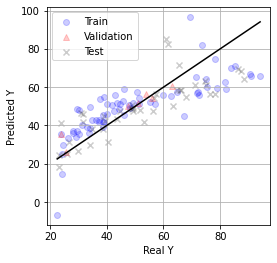

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, EN.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_val, EN.predict(X_val), alpha=0.2, c="red", marker='^', label='Validation')
plt.scatter(y_test, EN.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
rmse_sum['Linear Regression(ElasticNet)'] = [RMSE_train, RMSE_val, RMSE_test] 

## RF

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, rf.predict(X_train))
RMSE_train = mean_squared_error(y_train, rf.predict(X_train), squared=False)
R_square_val = r2_score(y_val, rf.predict(X_val))
RMSE_val = mean_squared_error(y_val, rf.predict(X_val), squared=False)
R_square_test = r2_score(y_test, rf.predict(X_test))
RMSE_test = mean_squared_error(y_test, rf.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Validation): {R_square_val}\nRMSE(Validation): {RMSE_val}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.9816377936527775
RMSE(Train): 2.6910884657525664

R_square(Validation): 0.8094335275869633
RMSE(Validation): 6.15250099354365

R_square(Test): 0.7547444061636608
RMSE(Test): 9.295923905545834


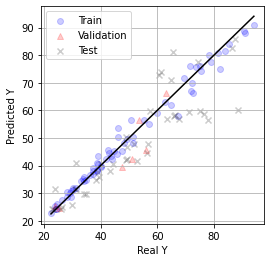

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, rf.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_val, rf.predict(X_val), alpha=0.2, c="red", marker='^', label='Validation')
plt.scatter(y_test, rf.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
rmse_sum['RF'] = [RMSE_train, RMSE_val, RMSE_test] 

## SVR

In [ ]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train, y_train)

SVR()

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, svr.predict(X_train))
RMSE_train = mean_squared_error(y_train, svr.predict(X_train), squared=False)
R_square_val = r2_score(y_val, svr.predict(X_val))
RMSE_val = mean_squared_error(y_val, svr.predict(X_val), squared=False)
R_square_test = r2_score(y_test, svr.predict(X_test))
RMSE_test = mean_squared_error(y_test, svr.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Validation): {R_square_val}\nRMSE(Validation): {RMSE_val}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.2268867475159514
RMSE(Train): 17.461723297401846

R_square(Validation): 0.5533513405381072
RMSE(Validation): 9.419144565945583

R_square(Test): 0.1612162244475882
RMSE(Test): 17.191275884129617


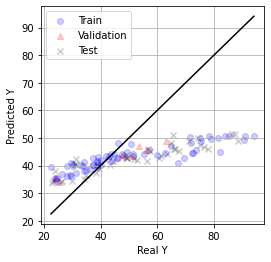

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, svr.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_val, svr.predict(X_val), alpha=0.2, c="red", marker='^', label='Validation')
plt.scatter(y_test, svr.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
rmse_sum['SVR'] = [RMSE_train, RMSE_val, RMSE_test] 

## GBR

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train, y_train)

gbr.predict(X_test[1:2])

gbr.score(X_test, y_test)

0.8149693943801471

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, gbr.predict(X_train))
RMSE_train = mean_squared_error(y_train, gbr.predict(X_train), squared=False)
R_square_val = r2_score(y_val, gbr.predict(X_val))
RMSE_val = mean_squared_error(y_val, gbr.predict(X_val), squared=False)
R_square_test = r2_score(y_test, gbr.predict(X_test))
RMSE_test = mean_squared_error(y_test, gbr.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Validation): {R_square_val}\nRMSE(Validation): {RMSE_val}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.9971116564254061
RMSE(Train): 1.0673085025309226

R_square(Validation): 0.7699612227343869
RMSE(Validation): 6.759724098576667

R_square(Test): 0.8149693943801471
RMSE(Test): 8.074300052098081


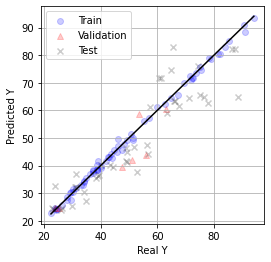

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, gbr.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_val, gbr.predict(X_val), alpha=0.2, c="red", marker='^', label='Validation')
plt.scatter(y_test, gbr.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
rmse_sum['GBR'] = [RMSE_train, RMSE_val, RMSE_test] 

## GpyTorch

In [ ]:
from sklearn.model_selection import train_test_split

X = lite_df.iloc[:, 1:-1].values
y = lite_df.iloc[:, -1].values

#Seperating literature data to training and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.09333333, random_state=5)

X_test = exp_df.iloc[:, 1:-1].values
y_test = exp_df.iloc[:, -1].values


In [ ]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# X must be in the range=(0, 1)
# use MinMaxScaler to transform features
mmscaler = MinMaxScaler()
X_train_mm = mmscaler.fit_transform(X_train)
X_val_mm = mmscaler.transform(X_val)
X_test_mm = mmscaler.transform(X_test)


X_train_tensor = torch.from_numpy(np.array(X_train_mm))
X_val_tensor = torch.from_numpy(np.array(X_val_mm))
X_test_tensor = torch.from_numpy(np.array(X_test_mm))


# Y must be in the range=(-1, 1)
y_scaler = StandardScaler()

y_train_s = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_val_s = y_scaler.fit_transform(y_val.reshape(-1, 1))
y_test_s = y_scaler.transform(y_test.reshape(-1, 1))

y_train_tensor = torch.from_numpy(np.array(y_train_s))
y_val_tensor = torch.from_numpy(np.array(y_val_s))
y_test_tensor = torch.from_numpy(np.array(y_test_s))

In [ ]:
kernel = RBFKernel(ard_num_dims=X.shape[1])

gp = SingleTaskGP(X_train_tensor, y_train_tensor, covar_module=kernel)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
  )
)

In [ ]:
from sklearn.metrics import r2_score

y_train_pred = gp.posterior(X_train_tensor).mean.detach().numpy().copy()
y_train_var = gp.posterior(X_train_tensor).variance.detach().numpy().copy()

y_val_pred = gp.posterior(X_val_tensor).mean.detach().numpy().copy()
y_val_var = gp.posterior(X_val_tensor).variance.detach().numpy().copy()

y_test_pred = gp.posterior(X_test_tensor).mean.detach().numpy().copy()
y_test_var = gp.posterior(X_test_tensor).variance.detach().numpy().copy()

#detach().numpy().copy()->change tensor to numpy
#https://tzmi.hatenablog.com/entry/2020/02/16/170928

R_square_train = r2_score(y_train_s, y_train_pred)
RMSE_train = mean_squared_error(y_scaler.inverse_transform(y_train_s), y_scaler.inverse_transform(y_train_pred), squared=False)
R_square_val = r2_score(y_val_s, y_val_pred)
RMSE_val = mean_squared_error(y_scaler.inverse_transform(y_val_s), y_scaler.inverse_transform(y_val_pred), squared=False)
R_square_test = r2_score(y_test_s, y_test_pred)
RMSE_test = mean_squared_error(y_scaler.inverse_transform(y_test_s), y_scaler.inverse_transform(y_test_pred), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Validation): {R_square_val}\nRMSE(Validation): {RMSE_val}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.9948211136888321
RMSE(Train): 1.0142537772706488

R_square(Validation): 0.7913808612953462
RMSE(Validation): 6.437326234931316

R_square(Test): 0.7674846414331082
RMSE(Test): 9.051257528705026


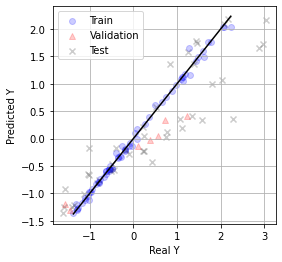

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train_s, y_train_pred, alpha=0.2, c="blue", label='Train')
plt.scatter(y_val_s, y_val_pred, alpha=0.2, c="red", marker='^', label='Validation')
plt.scatter(y_test_s, y_test_pred, alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train_s.min(), y_train_s.max()], [y_train_s.min(), y_train_s.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
rmse_sum['GP'] = [RMSE_train, RMSE_val, RMSE_test] 

# **Summary**

In [ ]:
summary = pd.DataFrame(rmse_sum, index=['Train', 'Validation', 'Test'])

In [ ]:
summary.style.set_caption("Table of RMSE")

,Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF,SVR,GBR,GP
Train,12.255265,12.252329,12.299659,2.691088,17.461723,1.067309,1.014254
Validation,4.727254,4.773634,4.750407,6.152501,9.419145,6.759724,6.437326
Test,11.385327,11.438010,11.367119,9.295924,17.191276,8.074300,9.051258


# **Feature Importance**

Text(0.5, 0, 'Feature Importance')

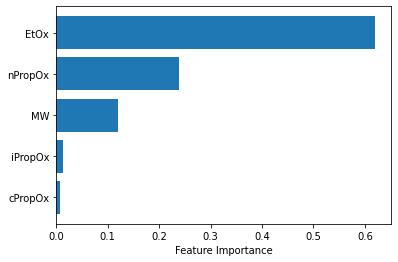

In [ ]:
#w/o ϕ
sort = rf.feature_importances_.argsort()
plt.barh(lite_std.iloc[:, 1:-1].columns[sort].astype(str)[-20:], rf.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

model_output = "margin" has been renamed to model_output = "raw"


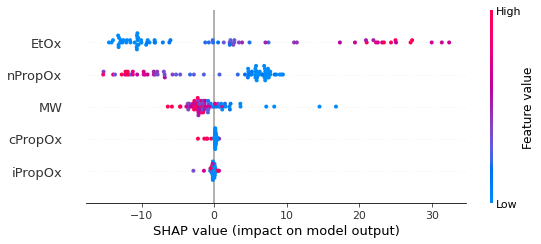

In [ ]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model=rf, feature_perturbation='tree_path_dependent', model_output='margin')
shap_values = explainer.shap_values(X=lite_std.iloc[:, 1:-1])
shap.summary_plot(shap_values, lite_std.iloc[:, 1:-1])

# **Bayesian Optimization**

## Analytic Acquisition Function

ExpectedImprovement (EI)

In [ ]:
from botorch.optim import optimize_acqf
from botorch.acquisition import ExpectedImprovement

EI = ExpectedImprovement(gp, best_f=0.2)

bounds = torch.stack([torch.zeros(5), torch.ones(5)*100])

candidate, acq_value = optimize_acqf(
    EI, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)

print(candidate)
print(acq_value)

tensor([[ 5.5494, 54.4384,  0.6211, 38.9743, 83.3594]])
tensor(0.2559, dtype=torch.float64)


In [ ]:
torch.ones(5)

tensor([1., 1., 1., 1., 1.])

Probability of Improvement (PI)

In [ ]:
from botorch.optim import optimize_acqf
from botorch.acquisition import ProbabilityOfImprovement

PI = ProbabilityOfImprovement(gp, best_f=0.2)

bounds = torch.stack([torch.zeros(5), torch.ones(5)])

candidate, acq_value = optimize_acqf(
    PI, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)

print(candidate)
print(acq_value)

tensor([[0.9993, 0.0023, 0.0264, 0.0000, 0.9559]])
tensor(1.0000, dtype=torch.float64)


Upper Condifence Bound (UCB)

In [ ]:
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound

UCB = UpperConfidenceBound(gp, beta=0.1)

bounds = torch.stack([torch.zeros(5), torch.ones(5)])

candidate, acq_value = optimize_acqf(
    UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)

print(candidate)
print(acq_value)

tensor([[9.7435e-01, 1.4647e-06, 0.0000e+00, 0.0000e+00, 8.2318e-01]])
tensor(1.0221, dtype=torch.float64)


## Monte-Carlo Acquisition Function

In [ ]:
from botorch.optim import optimize_acqf
from botorch.acquisition import qUpperConfidenceBound

qUCB = qUpperConfidenceBound(gp, beta=0.1)

bounds = torch.stack([torch.zeros(5), torch.ones(5)])

candidate, acq_value = optimize_acqf(
    qUCB, bounds=bounds, q=5, num_restarts=5, raw_samples=20, sequential=True
)

print(candidate)
print(acq_value)

tensor([[1.1640e-01, 0.0000e+00, 0.0000e+00, 8.2153e-04, 9.2887e-01],
        [6.5213e-02, 3.4436e-01, 4.4575e-01, 5.1137e-01, 2.6696e-01],
        [5.8183e-01, 4.8083e-01, 5.9165e-01, 1.7714e-01, 2.4202e-01],
        [6.0270e-01, 2.8527e-01, 2.5862e-02, 4.6553e-01, 9.5342e-01],
        [4.4291e-01, 1.6687e-02, 5.1360e-01, 2.3854e-01, 3.5704e-01]])
tensor([2.6556, 2.6555, 2.6556, 2.6558, 2.6556], dtype=torch.float64)
